#Detecting and diagnosing the bias in a facial detection system

In this project we implemnent a facial recognition model using a CNN and uncover the algorithmic biases which exists in facial detection model.

Do diagnose this we create a semi-supervised variational autoencoder(SS-VAE) which is going to do te taskof learning the hidden features from the latent space distribution underlying in the face image data set.

In [ ]:
!pip install mitdeeplearning
import tensorflow as tf
import IPython
import functools
import mitdeeplearning as mdl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117316 sha256=b836d67dd12f4807a63814893d364f66375a9ee95558f2a7bc035a302555048b
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


# Choosing the Dataset

We will require a dataset of positive instances (i.e., of faces) and a dataset of negative examples (i.e., of objects that are not faces) in order to train our facial detection models.
These data will be used to train our models to identify faces in images or not.

1.   Positive training data: CelebA Dataset(over 200k collective of celebrity faces)
2.   Negative training data: ImageNet(Images across various categories)

We will use a separate test dataset of face images, we will assess trained models in order to identify any potential bias, fairness, and confidence problems.

Change the sliders to see how the negative and positive daat samples look like

In [ ]:
# Get the training data: both images from CelebA and ImageNet
training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')

# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(training_data)

# Size of training data
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

1263889489/1263889489 [==============================] - 78s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


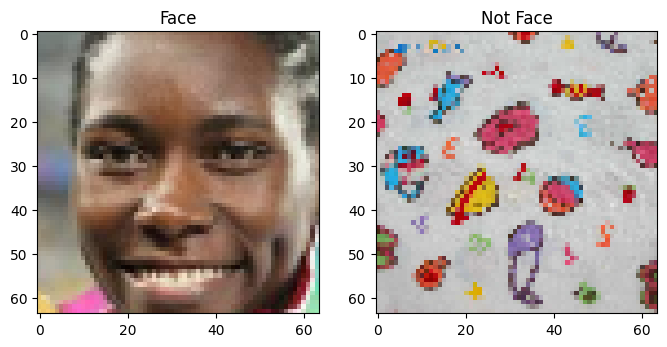

In [ ]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

# Examining the CelebA training dataset
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 22 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 24 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

# How we encounter the Bias

We will use the sizable, carefully maintained CelebA dataset (as well as ImageNet) to train our facial identification classifiers, then assess their performance as well as look for and identify any weaknesses in their operation. Our objective is to locate and characterize any potential problems and biases that may exist with the trained facial detection classifiers.

When we refer to a classifier as biased, what do we precisely mean? We must include latent variables, which characterize a dataset but are not rigorously observed, in order to formalize this. We refer to the probability distributions of the aforementioned latent variables as the latent space, as stated in the generative modeling course.

Combining these concepts, we define a classifier as biased if it changes its classification choice after seeing some additional latent features or variables. It will be beneficial to remember this definition of bias throughout the remainder of the lab.

We define and train a standard image classifier

In [ ]:
# Define the CNN model

n_filters = 12

def cnn_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

image_classifier = cnn_classifier()

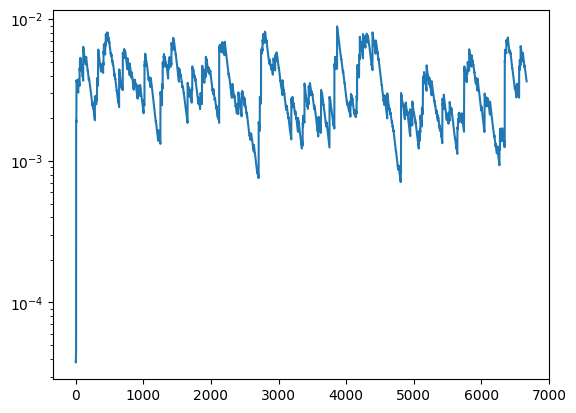

100%|██████████| 3434/3434 [00:35<00:00, 96.14it/s] 


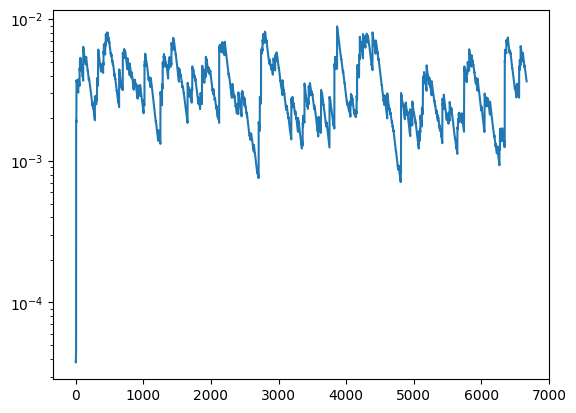

In [ ]:
# Train the standard CNN

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    logits = image_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, image_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, image_classifier.trainable_variables))
  return loss

# The training loop
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # batch of training data to propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [ ]:
# Evaluation of standard CNN

# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(image_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 0s 2ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9998


# Desiging a Semi SUpervised VAE
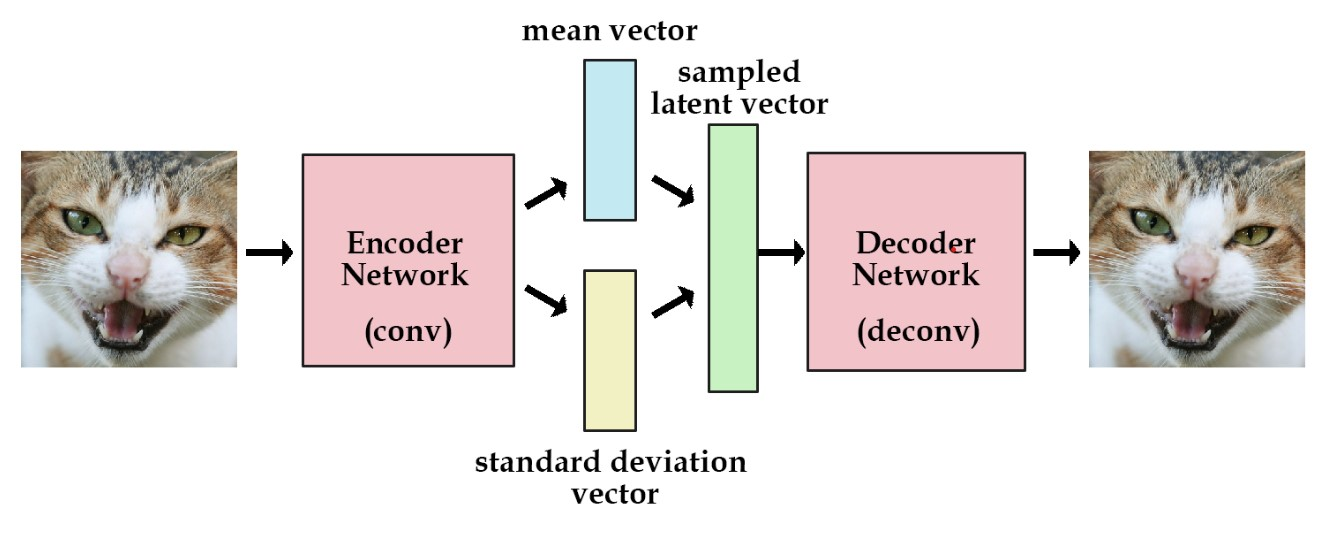

Our objective is to develop a model that adapts to the face training data by learning a representation of the underlying latent space. This type of learnt representation will reveal which traits are over- or under-represented in the data. Our model must be able to learn an encoding of the latent characteristics in the face data fully unsupervisedly, without any supervised annotation by us humans, in order to function. We use variational autoencoders (VAEs) to do this.

In [ ]:
# Define the decoder portion of the SS-VAE

def make_face_decoder_network(n_filters=12):
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape
  decoder = tf.keras.Sequential([
    Dense(units=4*4*6*n_filters),
    Reshape(target_shape=(4, 4, 6*n_filters)),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

# SS-VAE Architecture

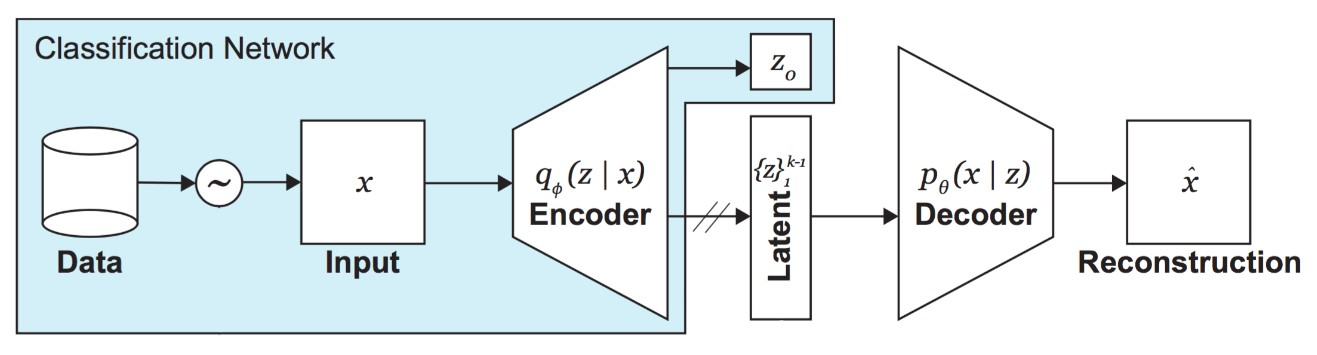

In [ ]:
class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = cnn_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]
    return y_logit, z_mean, z_logsigma

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = sampling(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)

NameError: ignored

# Loss function

For face images, our loss function will have two components:

1.   VAE loss: consists of the latent loss and the reconstruction loss.
2.   Classification loss: standard cross-entropy loss for a binary classification problem.

In [ ]:
# Defining the VAE loss function

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

# VAE Sampling
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

# Loss function for SS-VAE
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )
  return total_loss, classification_loss, vae_loss

In [ ]:
# Training the SS-VAE

batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 6
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def ss_vae_train_step(x, y):
  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, ss_vae.trainable_variables)
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for i in range(num_epochs):
  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, ss_vae)

NameError: ignored

# Link model performance to Uncertainty and Bias

Based on the features which are harder to learn for the VAE we can link the model performance.

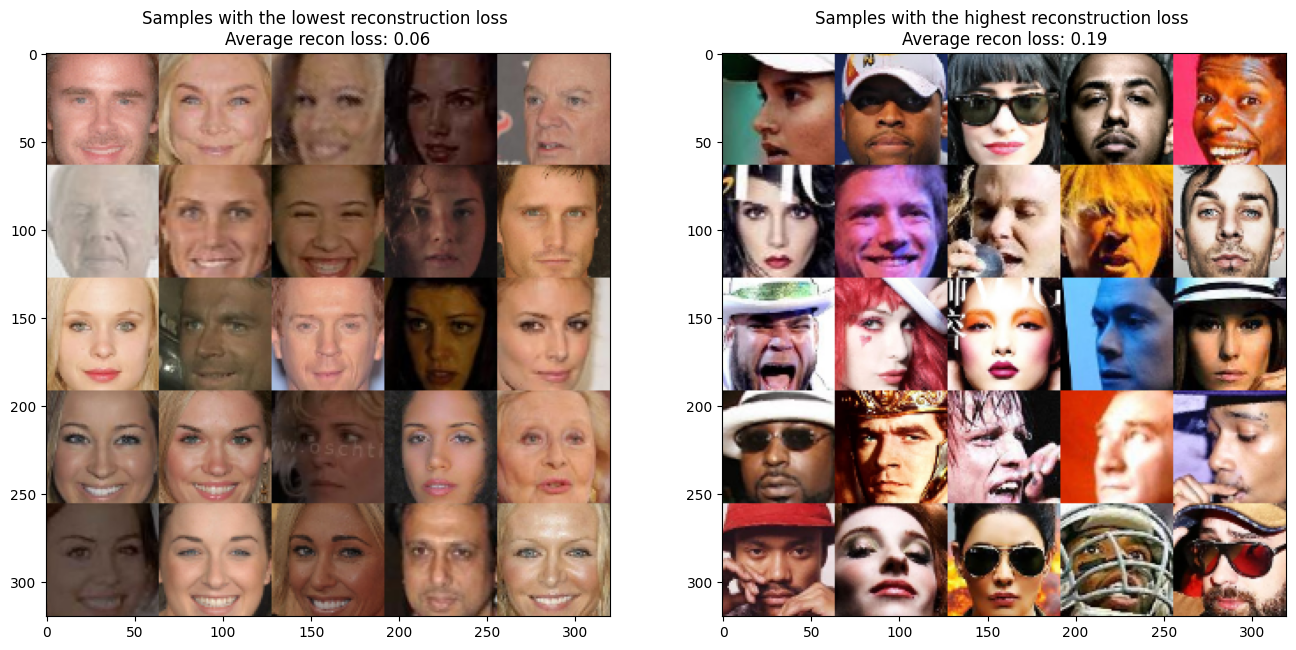

In [ ]:
# Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

# Uncovering hidden biases through learned latent features

As we've seen above, loss is an effective tool for identifying the samples in our dataset that the model had problems learning, or those with high model uncertainty. Nevertheless, bias is not always the same as this.
What are the relative frequencies and distributions of the various latent properties that the model has learned? How may these measures show hidden biases?

Let's look into how effectively the SS-VAE actually picked up on the faces' latent traits. To do this, we will examine specific latent features while maintaining the status quo for all other aspects, as well as the distribution of these features in the data and their related instances. We may look at the probabilistic distribution and form of the learnt latent features.

Additionally, marginalizing the effects of the other latent variables, we directly compare various values of individual latent variables to corresponding relative classification accuracies.

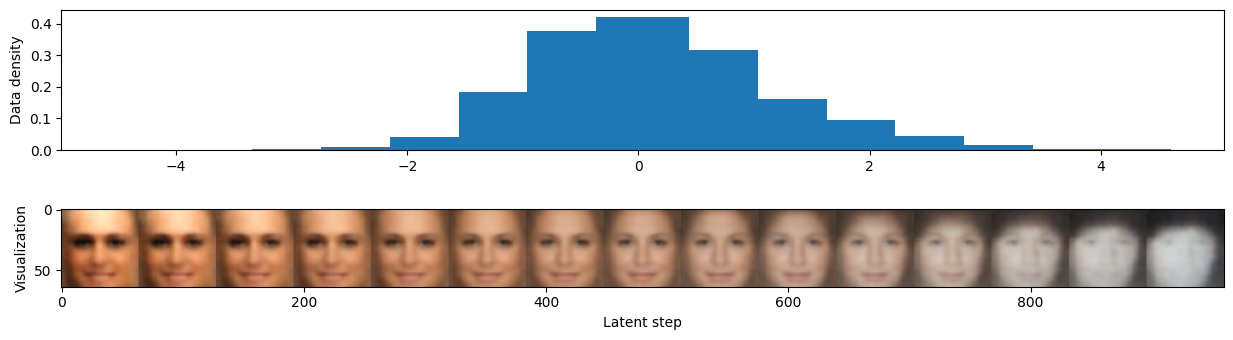

In [ ]:
# Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 0 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
  # Adjust the latent vector according to our step
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  # Decode the reconstruction and store
  recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");

Text(0, 0.5, 'Relative accuracy')

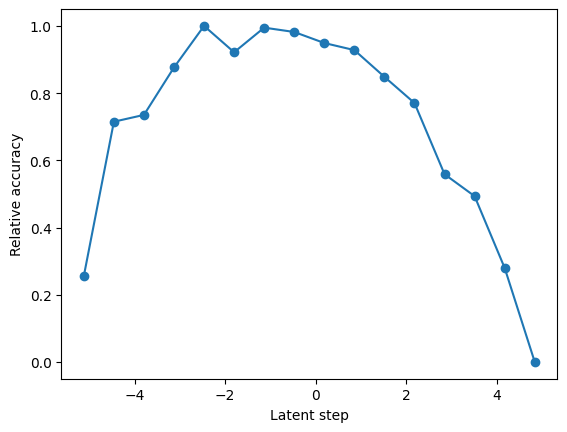

In [ ]:
# Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  # Find which samples fall in which bin of the latent dimension
  which_latent_bin = np.digitize(latent_samples, latent_steps)

  # For each latent bin, compute the accuracy (average logit score)
  avg_logit = []
  for j in range(0, num_steps+1):
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")